In [1]:
%pip install opendatasets

In [2]:
import os
import mlflow
import tempfile
import opendatasets as od
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import random as rd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import max_error, explained_variance_score, mean_absolute_error

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("HousePrice")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1664893595200, experiment_id='1', last_update_time=1664893595200, lifecycle_stage='active', name='HousePrice', tags={}>

## Cargamos los datos

In [4]:
od.download(
    "https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data"
    )

Skipping, found downloaded files in ".\house-prices-advanced-regression-techniques" (use force=True to force download)


In [5]:
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

## Exploracion de los datos

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
with pd.option_context('display.max_colwidth', None,
                       'display.max_columns', None,
                       'display.max_rows', None):
    print(train.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [9]:
# Quitamos las columnas con demasiados NaNs
test.drop(['PoolQC','Fence','MiscFeature','FireplaceQu','Alley' ,'Id'],axis=1,inplace=True)
train.drop(['PoolQC','Fence','MiscFeature','FireplaceQu','Alley' ,'Id'],axis=1,inplace=True)

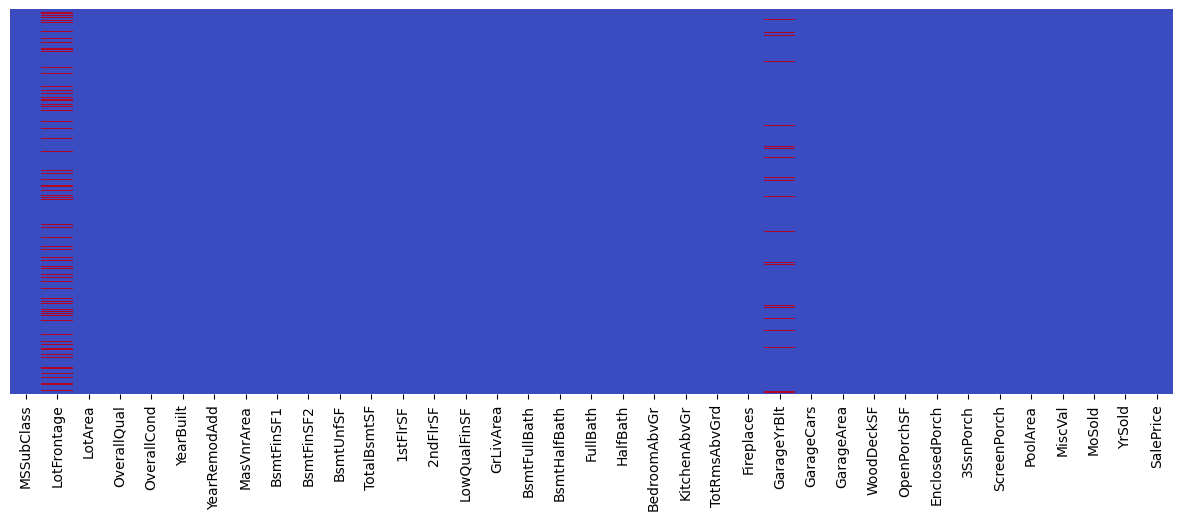

In [10]:
# Numerical features
plt.figure(figsize=(15,5))
sns.heatmap(train.select_dtypes(np.number).isnull(),cbar=False,cmap='coolwarm',yticklabels=False)
plt.show()

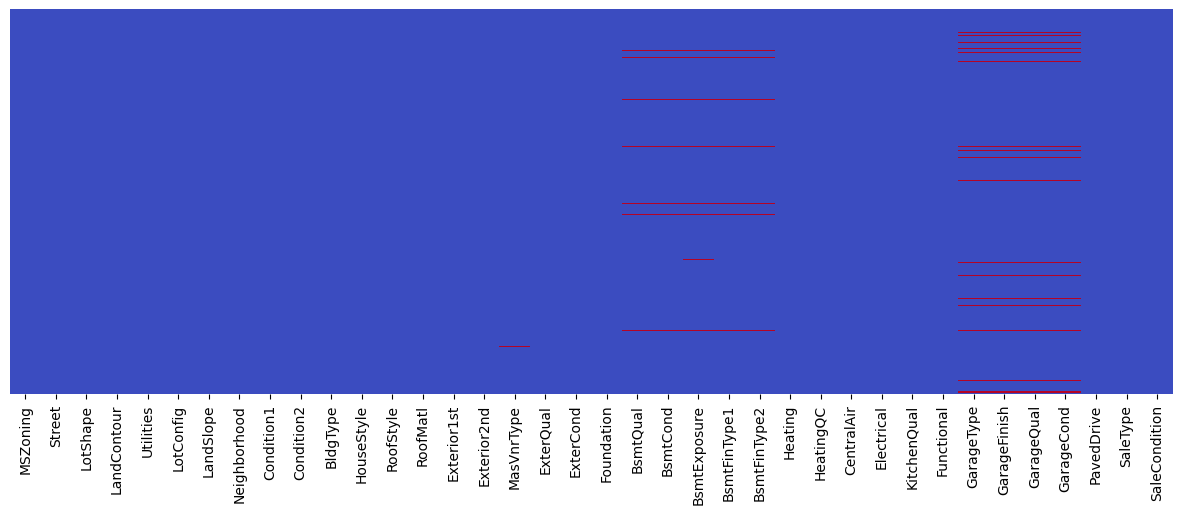

In [11]:
# Categorical features
plt.figure(figsize=(15,5))
sns.heatmap(train.select_dtypes(exclude=np.number).isnull(),cbar=False,cmap='coolwarm',yticklabels=False)
plt.show() 

## Division train test

In [12]:
seed = rd.randint(0,10000000)
rd.seed = seed
X_train, X_test, y_train, y_test = train_test_split(train.loc[:, train.columns != "SalePrice"], train.SalePrice, random_state=seed)
X_finaltest = test.loc[:, test.columns != "SalePrice"]

## Creamos la etapa de preprocesamiento

In [13]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ss", StandardScaler()),
    ("pca", PCA())
    ]
)

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ("nmf", NMF())
    ]
)

column_transformer = ColumnTransformer([
    ("categorical", cat_pipeline, list(test.select_dtypes(exclude=np.number).columns)),
    ("numerical", num_pipeline, list(test.select_dtypes(np.number).columns))
    ]
)

## Instanciamos los modelos

### DecisionTree

In [14]:
modelo_tree = Pipeline([
    ("prepr", column_transformer),
    ("modelo", DecisionTreeRegressor())
    ]
)

tree_param_grid = {
    'prepr__categorical__onehot__handle_unknown': ["ignore", "infrequent_if_exist"],
    'prepr__numerical__imputer__strategy': ["mean", "median", "most_frequent"],
    'prepr__numerical__pca__n_components': [10, 15, 20, None],
    'prepr__categorical__nmf__n_components':[10, 15, 20, None],
    'modelo__criterion': ['squared_error', "friedman_mse"],
    'modelo__max_features': ["sqrt", "log2", None],
}


### SupportVectorMachine

In [15]:
modelo_svm = Pipeline([
    ("prepr", column_transformer),
    ("modelo", SVR())
    ]
)

svm_param_grid = {
    'prepr__categorical__onehot__handle_unknown': ["ignore", "infrequent_if_exist"],
    'prepr__numerical__imputer__strategy': ["mean", "median", "most_frequent"],
    'prepr__numerical__pca__n_components': [10, 15, 20, None],
    'prepr__categorical__nmf__n_components':[10, 15, 20, None],
    'modelo__gamma': ['scale', 'auto'],
    'modelo__kernel': ['poly', 'rbf', 'sigmoid'],
}

### Random forest

In [16]:
modelo_forest = Pipeline([
    ("prepr", column_transformer),
    ("modelo", RandomForestRegressor())
    ]
)

forest_param_grid = {
    'prepr__categorical__onehot__handle_unknown': ["ignore", "infrequent_if_exist"],
    'prepr__numerical__imputer__strategy': ["mean", "median", "most_frequent"],
    'prepr__numerical__pca__n_components': [10, 15, 20, None],
    'prepr__categorical__nmf__n_components':[10, 15, 20, None],
    'modelo__criterion': ["squared_error", "absolute_error", "poisson"],
    'modelo__max_features': ["sqrt", "log2", None],
    'modelo__n_jobs': [-1],
}

## Instanciamos las búsquedas de hiperparámetros

In [17]:
tree_optimization = RandomizedSearchCV(modelo_tree, tree_param_grid, n_jobs=-1, scoring="neg_mean_absolute_error") 
forest_optimization = RandomizedSearchCV(modelo_svm, svm_param_grid, n_jobs=-1, scoring="neg_mean_absolute_error") 
svm_optimization = RandomizedSearchCV(modelo_forest, forest_param_grid, n_jobs=-1, scoring="neg_mean_absolute_error")

## Realizamos los experimentos

In [25]:
def experimento(optimization):
    with mlflow.start_run():
        model_name = str(optimization.estimator.named_steps["modelo"])[:-2]
        mlflow.log_param("model", model_name)
        mlflow.log_param("seed", seed)

        optimization.fit(X_train, y_train)

        best_params = optimization.best_estimator_.get_params()
        best_params = {k:best_params.get(k) for (k, v) in optimization.param_distributions.items()}
        mlflow.log_param("best_params", best_params)
        mlflow.log_param("search_space", optimization.param_distributions)

        y_pred_train = optimization.best_estimator_.predict(X_train)
        y_pred_test = optimization.best_estimator_.predict(X_test)
        
        mlflow.log_metric("best_cv_score.neg_mean_absolute_error", optimization.best_score_)
        # Regression metrics
        ## Explained Variance
        mlflow.log_metric("explained_variance.train", explained_variance_score(y_train, y_pred_train))
        mlflow.log_metric("explained_variance.test", explained_variance_score(y_test, y_pred_test))
        mlflow.log_metric("explained_variance.train", explained_variance_score(y_train, y_pred_train))
        mlflow.log_metric("explained_variance.test", explained_variance_score(y_test, y_pred_test))
        ## Max Error
        mlflow.log_metric("max_error.train", max_error(y_train, y_pred_train))
        mlflow.log_metric("max_error.test", max_error(y_test, y_pred_test))
        mlflow.log_metric("max_error.train", max_error(y_train, y_pred_train))
        mlflow.log_metric("max_error.test", max_error(y_test, y_pred_test)) 
        ## Mean Absolute Error
        mlflow.log_metric("mean_absolute_error.train", mean_absolute_error(y_train, y_pred_train))
        mlflow.log_metric("mean_absolute_error.test", mean_absolute_error(y_test, y_pred_test))
        mlflow.log_metric("mean_absolute_error.train", mean_absolute_error(y_train, y_pred_train))
        mlflow.log_metric("mean_absolute_error.test", mean_absolute_error(y_test, y_pred_test)) 


        mlflow.sklearn.log_model(optimization.best_estimator_, model_name+"_best_estimator")
        mlflow.sklearn.log_model(optimization, model_name+"_optimization")

In [26]:
experimento(tree_optimization)

c:\Users\Abelda-san\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [20]:
experimento(svm_optimization)

c:\Users\Abelda-san\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [21]:
experimento(forest_optimization)

c:\Users\Abelda-san\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [22]:
# TODO: Cambiar a gridsearch??